In [1]:
# System
import os

# Data processing
import numpy as np
import pandas as pd
import math as m
import datetime as dt

# Results presentation
from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

# NN related stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score

%matplotlib inline

In [2]:
SAVE_INFO = False

In [3]:
if (SAVE_INFO == True):
    DATA_DIR = 'Experiments/'
    EXPERIMENT_DIR = DATA_DIR + 'LSTM_dependency'
    os.makedirs(EXPERIMENT_DIR)

## Разбиение датасета по дням и по клеткам в сетке

In [4]:
LEFT_BORDER = 0
RIGHT_BORDER = 2000
DOWN_BORDER = 0
UP_BORDER = 2500

N_CELLS_HOR = 200
N_CELLS_VER = 250

R_CIRCLE = 50

In [5]:
celled_data = torch.load("Data/celled_data_" +
                         str(N_CELLS_HOR) + "x" +
                         str(N_CELLS_VER))

celled_data_cir = torch.load ("Data/celled_data_cir_R=" +
                              str(R_CIRCLE) + "_" +
                              str(N_CELLS_HOR) + "x" +
                              str(N_CELLS_VER))

In [6]:
def show_one_day_image (tensor, day):
    plt.imshow (tensor[day].squeeze(0), cmap=plt.cm.afmhot_r)
    plt.colorbar()
    
def show_one_day_quakes (tensor, day):
    state = tensor[day].squeeze(0)
    print (state.shape)
    X = []
    Y = []
    M = []
    for i in range(state.shape[0]):
        for j in range(state.shape[1]):
            if (state[i][j] != 0):
                X.append(i)
                Y.append(j)
                M.append(state[i][j].item())
    print (X)
    print (Y)
    print (M)
    
    fig = plt.figure(figsize=(8, 10))
    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    plt.axis([0, state.shape[0], 0, state.shape[1]])
    axes.scatter(X, Y, s=500, c=M, marker='.', cmap=plt.cm.Reds)
#     plt.colorbar()
    

torch.Size([200, 250])
[74, 88, 138, 149]
[89, 87, 169, 177]
[2.5, 2.5999999046325684, 3.700000047683716, 2.9000000953674316]


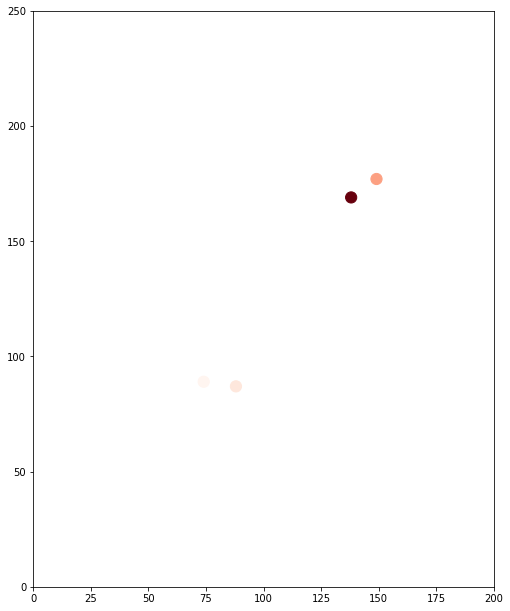

In [7]:
show_one_day_quakes (celled_data, 34)

# Обучение

In [8]:
DEVICE_ID = 3
DEVICE = torch.device('cuda:%d' % DEVICE_ID)
print (DEVICE)
# torch.cuda.set_device(DEVICE_ID)

cuda:3


In [9]:
def my_accuracy (input, target, threshold):
    true = ((input>threshold) == target)
    sum = torch.sum (true.float())
    return sum/input.shape[0]/input.shape[1]/input.shape[2]/input.shape[3]

def my_precision (input, target, threshold):
    TP = torch.sum (((input>threshold) * target      ).float())
    FP = torch.sum (((input>threshold) * (1 - target)).float())
    return TP / (TP + FP)

def my_recall (input, target, threshold):
    TP = torch.sum ((     (input>threshold)  * target).float())
    FN = torch.sum (((1 - (input>threshold)) * target).float())
    return TP / (TP + FN)

def my_precision_recall (input, target, threshold):
    TP = torch.sum ((     (input>threshold)  * target      ).float())
    FP = torch.sum ((     (input>threshold)  * (1 - target)).float())
    FN = torch.sum (((1 - (input>threshold)) * target      ).float())
#     print ('TP = ', TP.item(), 'FP = ', FP.item(), 'FN = ', FN.item(), 'N = ', input.shape[0])
    return TP / (TP + FP), TP / (TP + FN)

def my_precision_TPR_FPR (input, target, threshold):
    TP = torch.sum ((     (input>threshold) .float() * target      ).float())
    FP = torch.sum ((     (input>threshold) .float() * (1 - target)).float())
    FN = torch.sum (((1 - (input>threshold)).float() * target      ).float())
    TN = torch.sum (((1 - (input>threshold)).float() * (1 - target)).float())
    return TP / (TP + FP), TP / (TP + FN), FP / (FP + TN)

def my_TP_FN_FP_TN (input, target, threshold):
    matrix = np.zeros((2, 2))
    matrix[0, 0] = torch.sum ((     (input>threshold) .float() * target      ).float())
    matrix[1, 0] = torch.sum ((     (input>threshold) .float() * (1 - target)).float())
    matrix[0, 1] = torch.sum (((1 - (input>threshold)).float() * target      ).float())
    matrix[1, 1] = torch.sum (((1 - (input>threshold)).float() * (1 - target)).float())
    return matrix / np.sum(matrix)

### Создадим датасет
#### (Может не влезть в оперативку (надо ~ 12Gb))

In [10]:
OBSERVED_DAYS = 64     # ~2 months
DAYS_TO_PREDICT_AFTER  = 10
DAYS_TO_PREDICT_BEFORE = 50
TESTING_DAYS = 1000

In [11]:
class EarthquakeDataset_RNN_Train (Dataset):
    def __init__(self, celled_data, heavy_quake_thres):
        self.heavy_quake_thres = heavy_quake_thres
        self.mean_val = (celled_data>heavy_quake_thres).float().mean(dim=0)
        self.data = celled_data[0:
                                (celled_data.shape[0] -
                                 TESTING_DAYS)]
        self.size = (self.data.shape[0] -
                     DAYS_TO_PREDICT_BEFORE)
        
#         print ('self.data :', self.data.shape)
#         print ('size      :', self.size)
        
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        accurate_pred = ((torch.sum(self.data[(idx +
                                               DAYS_TO_PREDICT_AFTER):
                                              (idx +
                                               DAYS_TO_PREDICT_BEFORE)] > self.heavy_quake_thres,
                                    dim=0,
                                    keepdim=True).squeeze(0) > 0).float()
                          - self.mean_val)
        return (self.data[(idx)],
                torch.cat([1 - accurate_pred, accurate_pred], dim=0))
        

class EarthquakeDataset_RNN_Test (Dataset):
    def __init__(self, celled_data, heavy_quake_thres):
        self.heavy_quake_thres = heavy_quake_thres
        self.mean_val = (celled_data>heavy_quake_thres).float().mean(dim=0)
        self.data = celled_data[(celled_data.shape[0] -
                                 TESTING_DAYS):
                                (celled_data.shape[0])]
        self.size = (self.data.shape[0] -
                     DAYS_TO_PREDICT_BEFORE)
        
#         print ('self.data :', self.data.shape)
#         print ('size      :', self.size)
        
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        return (self.data[(idx)],
                torch.sum(self.data[(idx +
                                     DAYS_TO_PREDICT_AFTER):
                                    (idx +
                                     DAYS_TO_PREDICT_BEFORE)] > self.heavy_quake_thres,
                          dim=0,
                          keepdim=True).squeeze(0) > 0)
    
class EarthquakeDataset_RNN_Test_Cir (Dataset):
    def __init__(self, celled_data, celled_data_cir, heavy_quake_thres):
        self.heavy_quake_thres = heavy_quake_thres
        self.mean_val = (celled_data>heavy_quake_thres).float().mean(dim=0)
        
        self.data = celled_data[(celled_data.shape[0] -
                                 TESTING_DAYS):
                                (celled_data.shape[0])]
        self.target = celled_data_cir[(celled_data.shape[0] -
                                       TESTING_DAYS):
                                      (celled_data.shape[0])]
        self.size = (self.data.shape[0] -
                     DAYS_TO_PREDICT_BEFORE)
        
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        return (self.data[(idx)],
                torch.sum(self.target[(idx +
                                       DAYS_TO_PREDICT_AFTER):
                                      (idx +
                                       DAYS_TO_PREDICT_BEFORE)] > self.heavy_quake_thres,
                          dim=0,
                          keepdim=True).squeeze(0) > 0)


### Создадим саму сеть

In [12]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        
        self.CONV  = nn.Conv2d    (in_channels,
                                   out_channels,
                                   kernel_size=kernel_size,
                                   stride=stride,
                                   padding=padding,
                                   bias=False)             # think about it later
        
        self.BNORM =nn.BatchNorm2d(out_channels,
                                   eps=1e-05,
                                   momentum=0.1,
                                   affine=False)
#         self.RELU  = nn.ReLU ()
        
#         self.MAXPOOL = nn.MaxPool2d(3,
#                                     stride=1,
#                                     padding=1,
#                                     dilation=1)
        
    def forward(self, x):
        #print ('sizeof(x) = ', x.size())
        #print ('sizeof(xprev) = ', xprev.size())    
        
        x = self.CONV   (x)
        x = self.BNORM  (x)
#         x = self.RELU   (x)
#         x = self.MAXPOOL(x)
        
        return x

In [13]:
class RNNCell (nn.Module):
    
    def __init__(self, embedding_size=16, hidden_state_size=32):
        super(self.__class__,self).__init__()
        
        self.emb_size = embedding_size
        self.  h_size = hidden_state_size
        
        self.embedding  = ConvBlock (1, embedding_size, 3)
        self.RNN_update = nn.Sequential (ConvBlock (hidden_state_size + embedding_size,
                                                    hidden_state_size + embedding_size,
                                                    kernel_size=3),
                                         ConvBlock (hidden_state_size + embedding_size,
                                                    hidden_state_size,
                                                    kernel_size=3))
        self.RNN_to_result = nn.Sequential (ConvBlock (hidden_state_size, 
                                                       2, 
                                                       kernel_size=3),
                                            nn.Softmax (dim=1))
        
    def forward (self, x, h_prev):
        
        x_emb   = self.embedding (x)
        x_and_h = torch.cat([x_emb, h_prev], dim=1)
#         print ("x_and_h : ", x_and_h.shape)
        h_next  = self.RNN_update(x_and_h)
#         print ("h_prev :", h_prev.shape)
#         print ("h_next :", h_next.shape)
        
        assert h_prev.shape == h_next.shape
        
        h_next = F.tanh(h_next)
        result = self.RNN_to_result(h_next)
        return h_next, result
    
    def init_state (self, batch_size, device=torch.device("cpu")):
        return torch.zeros(batch_size,
                           self.h_size,
                           N_CELLS_HOR, 
                           N_CELLS_VER,
                           requires_grad=False,
                           device=device)

In [14]:
class StupidNetCell (nn.Module):
    
    def __init__(self):
        super(self.__class__,self).__init__()
        
    def forward (self, x, prev_state):
        ret = torch.zeros([x.shape[0], 2, N_CELLS_HOR, N_CELLS_VER])
        for i in range(x.shape[0]):
            ret[i, 0] = freq_map
            ret[i, 1] = freq_map
        return 0, ret
    
    def init_state (self, batch_size, device=torch.device("cpu")):
        return 0
    

### LSTM
![LSTM](./img/LSTM.png)

In [15]:
class LSTMCell (nn.Module):
    
    def __init__ (self,
                  embedding_size=16,
                  hidden_state_size=32):
        super(self.__class__,self).__init__()
        
        self.emb_size = embedding_size
        self.hid_size = hidden_state_size
        
#         self.embedding = ConvBlock (1, self.emb_size, kernel_size=3)
        self.embedding = nn.Sequential(ConvBlock(1,
                                                 self.emb_size,
                                                 3),
                                       nn.ReLU(),
                                       ConvBlock(self.emb_size,
                                                 self.emb_size,
                                                 3))
        self.hidden_to_result = nn.Sequential (ConvBlock (hidden_state_size, 
                                                          2, 
                                                          kernel_size=3),
                                               nn.Softmax (dim=1))
        
        self.f_t = nn.Sequential (ConvBlock(self.hid_size + self.emb_size,
                                            self.hid_size,
                                            3),
                                  nn.Sigmoid())
        self.i_t = nn.Sequential (ConvBlock(self.hid_size + self.emb_size,
                                            self.hid_size,
                                            3),
                                  nn.Sigmoid())
        self.c_t = nn.Sequential (ConvBlock(self.hid_size + self.emb_size,
                                            self.hid_size,
                                            3),
                                  nn.Tanh())
        self.o_t = nn.Sequential (ConvBlock(self.hid_size + self.emb_size,
                                            self.hid_size,
                                            3),
                                  nn.Sigmoid())
        
    def forward (self, x, prev_state):
        (prev_c, prev_h) = prev_state
        x_emb = self.embedding(x)
        
        x_and_h = torch.cat([prev_h, x_emb], dim=1)
        
        f_i = self.f_t(x_and_h)
        i_i = self.i_t(x_and_h)
        c_i = self.c_t(x_and_h)
        o_i = self.o_t(x_and_h)
        
        next_c = prev_c * f_i + i_i * c_i
        next_h = torch.tanh(next_c) * o_i
        
        assert prev_h.shape == next_h.shape
        assert prev_c.shape == next_c.shape
        
        return (next_c, next_h), self.hidden_to_result(next_h)
        
    def init_state (self, batch_size, device=torch.device("cpu")):
        return (Variable(torch.zeros(batch_size,
                                     self.hid_size,
                                     N_CELLS_HOR,
                                     N_CELLS_VER,
                                     device=device)),
                Variable(torch.zeros(batch_size,
                                     self.hid_size,
                                     N_CELLS_HOR,
                                     N_CELLS_VER,
                                     device=device)))
               
    

#### Функция тренеровки

In [16]:
def my_crossEntropy(weights, prediction, target):
    assert len(weights) == prediction.shape[1]
    assert prediction.shape == target.shape
    loss = 0
    for i in range(prediction.shape[0]):
        for j in range(len(weights)):
            loss -= weights[j] * torch.sum(target[i, j] * prediction[i, j].log())
    return loss

In [17]:
def train_network_RNN (RNN_cell,
                       device,
                       dataloader_train,
                       n_cycles=1,
                       learning_rate=0.0003,
                       earthquake_weight=1.,
                       lr_decay=1.):
    
    loss_massive = []
    i = 0
    
    RNN_cell.to(device)
    
    weights = torch.tensor([1., earthquake_weight], dtype=torch.float).to(device)
#     criterion = nn.CrossEntropyLoss(weights)
    
    i = 0
    for cycle in range(n_cycles):
        
        optimizer = torch.optim.Adam(RNN_cell.parameters(), lr=learning_rate)
        optimizer.zero_grad()
        
        hid_state = RNN_cell.init_state(batch_size=1, device=device)
        for data in tqdm(dataloader_train):
            
            inputs = data[0].to(device)
            labels = data[1].to(device)
            
#             print ("inputs", inputs.shape)
#             print ("hid_state", hid_state.shape)
            hid_state, outputs = RNN_cell.forward(inputs, hid_state)
            
#             loss = criterion(outputs, labels.squeeze(1).long())
            loss = my_crossEntropy(weights, outputs, labels)
            loss_massive.append(loss.item())
#             loss.backward(retain_graph=True)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
#             print ("day : ", i, "loss : ", loss.item())
            
            if (type(hid_state) == tuple):
                for elem in hid_state:
                    elem.detach_()
            else:
                hid_state.detach_()
            
#             if (i)%100==0:
#                 clear_output(True)
#                 print ("Done :", i, "/", dataloader_train.__len__())
#                 plt.plot(loss_massive,label='loss')
#                 plt.legend()
#                 plt.show()
            i += 1
        learning_rate /= lr_decay
         

In [18]:
N_CYCLES = 1
LEARNING_RATE = 0.0003
LR_DECAY = 10.
EARTHQUAKE_WEIGHT = 1000.

In [19]:
EMB_SIZE = 16
HID_SIZE = 32

In [20]:
# # RNN_cell = RNNCell()
# RNN_cell = LSTMCell(embedding_size    = EMB_SIZE,
#                     hidden_state_size = HID_SIZE)
# train_network_RNN (RNN_cell,
#                    DEVICE,
#                    earthquakes_dataloader_train,
#                    n_cycles=N_CYCLES,
#                    learning_rate=LEARNING_RATE,
#                    earthquake_weight=EARTHQUAKE_WEIGHT,
#                    lr_decay=LR_DECAY
#                    )

In [21]:
def check_quality (RNN_cell,
                   device,
                   dataloader_test,
                   n_dots=501,
                   info_file=None):
    
    prediction = torch.zeros(dataloader_test.__len__(),  N_CELLS_HOR, N_CELLS_VER,
                             device=device,
                             dtype=torch.float)
    prediction.detach_()
    target     = torch.zeros(dataloader_test.__len__(), N_CELLS_HOR, N_CELLS_VER,
                             device=device,
                             dtype=torch.float)
    target.detach_()
       
    RNN_cell.to(device)

    hid_state = RNN_cell.init_state(batch_size=1, device=device)
    if (type(hid_state) == tuple):
        for elem in hid_state:
            elem.detach_()
    else:
        hid_state.detach_()
        
    for data in tqdm(dataloader_test):

        inputs = data[0].to(device)
        labels = data[1].to(device).float()

        hid_state, outputs = RNN_cell.forward(inputs, hid_state)
        
        prediction[i] = outputs[:, 1, :, :]
        target    [i] = labels.squeeze(0)
    
        if (type(hid_state) == tuple):
            for elem in hid_state:
                elem.detach_()
        else:
            hid_state.detach_()
        prediction.detach_()
        target    .detach_()
        
    assert prediction.shape == target.shape
    prediction = prediction [10:prediction.shape[0]]  # cutting peace of data because
    target     = target     [10:target    .shape[0]]  # hidden state might be not good
    
    print ("ROC_AUC_score = ", end='')
    ROC_AUC_score = roc_auc_score(np.array(target    .view(-1).cpu()),
                                  np.array(prediction.view(-1).cpu()))
    print (ROC_AUC_score)
    if (SAVE_INFO):
        print ('ROC_AUC               =', ROC_AUC_score, file=info_file)
    
    print ("AVG_precision_score = ", end='')
    AVG_precision_score = average_precision_score(np.array(target    .view(-1).cpu()),
                                                  np.array(prediction.view(-1).cpu()))
    print (AVG_precision_score)
    if (SAVE_INFO):
        print ('Average_precision     =', AVG_precision_score, file=info_file)
        
    print ('\n=======================')
    
    for threshold in (0.2, 0.4, 0.6, 0.8):
        print ('Threshold = ', threshold)
        print ('-----------------------')
        print (my_TP_FN_FP_TN(prediction, target, threshold))
        print ('=======================')
    
    if SAVE_INFO:
        print ('\n=======================', file=info_file)
    
        for threshold in (0.2, 0.4, 0.6, 0.8):
            print ('Threshold = ', threshold                    , file=info_file)
            print ('-----------------------'                    , file=info_file)
            print (my_TP_FN_FP_TN(prediction, target, threshold), file=info_file)
            print ('======================='                    , file=info_file)
    
    threshold_massive = torch.linspace (0, 1, n_dots, dtype=torch.float, device=device)
    
#     precision = np.zeros(n_dots)
#     recall    = np.zeros(n_dots)
#     FPR       = np.zeros(n_dots)

    precision_massive = []
    recall_massive    = []
    FPR_massive       = []
    
    for threshold in tqdm(threshold_massive):
        precision, recall, FPR = my_precision_TPR_FPR(prediction, target, threshold)
        precision_massive.append(precision.item())
        recall_massive   .append(recall.item())
        FPR_massive      .append(FPR.item())
    
    # plot 1 precision
    fig = plt.figure(figsize=(10, 6))

    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

    axes.plot(np.array(threshold_massive.cpu()), precision_massive, color='green', marker='^')

    axes.set_xlabel('threshold')
    axes.set_ylabel('precision')

    if (SAVE_INFO == True):
        plt.savefig(EXPERIMENT_DIR + 'Precision_from_threshold.png', format='png', dpi=100)
    plt.show()
    
    # plot 2 recall
    fig = plt.figure(figsize=(10, 6))

    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

    axes.plot(np.array(threshold_massive.cpu()), recall_massive, color='green', marker='^')

    axes.set_xlabel('threshold')
    axes.set_ylabel('recall')
    
    if (SAVE_INFO == True):
        plt.savefig(EXPERIMENT_DIR + 'Recall_from_threshold.png', format='png', dpi=100)
    plt.show()
    
    # plot 3 ROC-curve
    fig = plt.figure(figsize=(8, 8))

    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

    axes.plot(FPR_massive, recall_massive, 'orange', marker = '^')
    axes.plot (range(2), range(2), 'grey', ls='--')

    axes.set_xlabel('FPR')
    axes.set_ylabel('TPR (recall)')
    axes.set_title('ROC-curve')

    if (SAVE_INFO == True):
        plt.savefig(EXPERIMENT_DIR + 'ROC_curve.png', format='png', dpi=100)
    plt.show()
    
    # plot 4 precision-recall-curve
    fig = plt.figure(figsize=(8, 8))

    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

    axes.plot(recall_massive, precision_massive, 'orange', marker = '^')

    axes.set_xlabel('Recall')
    axes.set_ylabel('Precision')
    axes.set_title('Precision_Recall_curve')

    if (SAVE_INFO == True):
        plt.savefig(EXPERIMENT_DIR + 'Precision_Recall_curve.png', format='png', dpi=100)
    plt.show()
    
    return ROC_AUC_score, AVG_precision_score

In [22]:
def max_F1_score(target, prediction):
    max_F1 = 0
    for i in np.linspace(0, 1, 21):
        F1 = f1_score(target, prediction>i)
        max_F1 = max(max_F1, F1)
    
    return max_F1

In [23]:
def calculate_metrics(RNN_cell,
                      device,
                      dataloader_test):
    
    prediction = torch.zeros(dataloader_test.__len__(),  N_CELLS_HOR, N_CELLS_VER,
                             device=device,
                             dtype=torch.float)
    prediction.detach_()
    target     = torch.zeros(dataloader_test.__len__(), N_CELLS_HOR, N_CELLS_VER,
                             device=device,
                             dtype=torch.float)
    target.detach_()
       
    RNN_cell.to(device)

    hid_state = RNN_cell.init_state(batch_size=1, device=device)
    if (type(hid_state) == tuple):
        for elem in hid_state:
            elem.detach_()
    else:
        hid_state.detach_()
    
    i = 0
    for data in tqdm(dataloader_test):

        inputs = data[0].to(device)
        labels = data[1].to(device).float()

        hid_state, outputs = RNN_cell.forward(inputs, hid_state)
        
        prediction[i] = outputs[:, 1, :, :]
        target    [i] = labels.squeeze(0)
    
        if (type(hid_state) == tuple):
            for elem in hid_state:
                elem.detach_()
        else:
            hid_state.detach_()
        prediction.detach_()
        target    .detach_()
        i += 1
    
    assert prediction.shape == target.shape
    prediction = prediction [10:prediction.shape[0]]  # cutting peace of data because
    target     = target     [10:target    .shape[0]]  # hidden state might be not good
    
    prediction += dataloader_test.dataset.mean_val.to(device)
    
    ROC_AUC_score = roc_auc_score(np.array(target    .view(-1).cpu()),
                                  np.array(prediction.view(-1).cpu()))
    
    
    AVG_precision_score = average_precision_score(np.array(target    .view(-1).cpu()),
                                                  np.array(prediction.view(-1).cpu()))
    
    F1_score = max_F1_score(np.array(target    .view(-1).cpu()),
                            np.array(prediction.view(-1).cpu()))
    
    precision, recall, _ = precision_recall_curve(np.array(target    .view(-1).cpu()),
                                                  np.array(prediction.view(-1).cpu()))
    
    prec_rec_AUC = auc (recall, precision)

    return ROC_AUC_score, AVG_precision_score, F1_score, prec_rec_AUC
    
    

In [24]:
def calculate_pos_class_portion (device,
                                 dataloader):

    n_pos = 0
    n_all = 0
    
    for data in tqdm(dataloader):

        labels = data[1][:, 1, :, :].to(device).float() + dataloader.dataset.mean_val.to(device)
        
        n_pos += torch.sum(labels).item()
        n_all += (labels.shape[0] *
                  labels.shape[1] *
                  labels.shape[2])

    return (n_pos / (n_all - n_pos))

In [25]:
def init_results (thresholds_range, n_launches):
    results = pd.DataFrame({"threshold"       :[0 for i in range(len(thresholds_range))],
                            "portion"         :[[0]*n_launches for i in range(len(thresholds_range))],
                            "weight"          :[[0]*n_launches for i in range(len(thresholds_range))],
                            "avg_prec"        :[[0]*n_launches for i in range(len(thresholds_range))],
                            "roc_auc"         :[[0]*n_launches for i in range(len(thresholds_range))],
                            "max_F1"          :[[0]*n_launches for i in range(len(thresholds_range))],
                            "prec_rec_auc"    :[[0]*n_launches for i in range(len(thresholds_range))],
                            "ext_avg_prc"     :[[0]*n_launches for i in range(len(thresholds_range))],
                            "ext_roc_auc"     :[[0]*n_launches for i in range(len(thresholds_range))],
                            "ext_max_F1"      :[[0]*n_launches for i in range(len(thresholds_range))],
                            "ext_prec_rec_auc":[[0]*n_launches for i in range(len(thresholds_range))]})
    for i in range(len(thresholds_range)):
        results.loc[i, "threshold"]        = thresholds_range[i]
        
#         results.loc[i, "avg_prec"]         = []
#         results.loc[i, "roc_auc"]          = []
#         results.loc[i, "max_F1"]           = []
#         results.loc[i, "prec_rec_auc"]     = []
        
#         results.loc[i, "ext_avg_prc"]      = []
#         results.loc[i, "ext_roc_auc"]      = []
#         results.loc[i, "ext_max_F1"]       = []
#         results.loc[i, "ext_prec_rec_auc"] = []
    return results

def calc_metrics_from_threshold (RNN_class,
                                device,
                                thresholds_range,
                                learning_rate=0.0003,
                                n_cycles=1,
                                lr_decay=1.,
                                n_launches=1):
    
    results = init_results(thresholds_range, n_launches)
    print (results)
    
    i = 0
    for heavy_threshold in tqdm(thresholds_range):
        os.mkdir("ready/"+str(i))
        
        dataset_train    = EarthquakeDataset_RNN_Train    (celled_data,
                                                           heavy_threshold)
        dataset_test     = EarthquakeDataset_RNN_Test     (celled_data,
                                                           heavy_threshold)
        dataset_test_cir = EarthquakeDataset_RNN_Test_Cir (celled_data,
                                                           celled_data_cir,
                                                           heavy_threshold)
        
        dataloader_train = DataLoader(dataset_train,
                                      batch_size=1,
                                      shuffle=False,
                                      num_workers=1)
        dataloader_test  = DataLoader(dataset_test,
                                      batch_size=1,
                                      shuffle=False,
                                      num_workers=1)
        dataloader_test_cir = DataLoader(dataset_test_cir,
                                         batch_size=1,
                                         shuffle=False,
                                         num_workers=1)
        
        portion = calculate_pos_class_portion(device,
                                              dataloader_train)
        results.loc[i, "portion"] = portion
        weight = 1 / portion
        results.loc[i, "weight"]  = weight
        
        print ("threshold = ", heavy_threshold,
               "portion = ", portion,
               "weight = ", weight)
        
        for k in range(n_launches):
            RNN_cell = RNN_class(embedding_size    = EMB_SIZE,
                                 hidden_state_size = HID_SIZE)
#             RNN_cell = RNN_class()
            train_network_RNN (RNN_cell,
                               device,
                               dataloader_train,
                               n_cycles=n_cycles,
                               learning_rate=learning_rate,
                               earthquake_weight=weight,
                               lr_decay=lr_decay)
            RNN_cell.eval()
            (roc_auc,
             avg_prec,
             F1,
             prec_rec_auc)     = calculate_metrics(RNN_cell,
                                                   device,
                                                   dataloader_test)
            (ext_roc_auc,
             ext_avg_prec,
             ext_F1,
             ext_prec_rec_auc) = calculate_metrics(RNN_cell,
                                                   device,
                                                   dataloader_test_cir)
    
            results.loc[i, "avg_prec"]         [k] = avg_prec
            results.loc[i, "roc_auc"]          [k] = roc_auc
            results.loc[i, "max_F1"]           [k] = F1
            results.loc[i, "prec_rec_auc"]     [k] = prec_rec_auc

            results.loc[i, "ext_avg_prc"]      [k] = ext_avg_prec
            results.loc[i, "ext_roc_auc"]      [k] = ext_roc_auc
            results.loc[i, "ext_max_F1"]       [k] = ext_F1
            results.loc[i, "ext_prec_rec_auc"] [k] = ext_prec_rec_auc
            
            os.mkdir("ready/"+str(i)+"/"+str(k))
            results.to_csv("ready/result")
        
        print (results)
        i += 1
    return results

In [ ]:
results = calc_metrics_from_threshold (LSTMCell,
                                       DEVICE,
                                       (4.5, 5.7, 5.8, 5.9, 6.0, 6.1),
                                       learning_rate=LEARNING_RATE,
                                       n_cycles=N_CYCLES,
                                       lr_decay=LR_DECAY,
                                       n_launches=8)

    threshold                   portion                    weight  \
0         4.5  [0, 0, 0, 0, 0, 0, 0, 0]  [0, 0, 0, 0, 0, 0, 0, 0]   
1         4.9  [0, 0, 0, 0, 0, 0, 0, 0]  [0, 0, 0, 0, 0, 0, 0, 0]   
2         5.0  [0, 0, 0, 0, 0, 0, 0, 0]  [0, 0, 0, 0, 0, 0, 0, 0]   
3         5.1  [0, 0, 0, 0, 0, 0, 0, 0]  [0, 0, 0, 0, 0, 0, 0, 0]   
4         5.2  [0, 0, 0, 0, 0, 0, 0, 0]  [0, 0, 0, 0, 0, 0, 0, 0]   
5         5.3  [0, 0, 0, 0, 0, 0, 0, 0]  [0, 0, 0, 0, 0, 0, 0, 0]   
6         5.4  [0, 0, 0, 0, 0, 0, 0, 0]  [0, 0, 0, 0, 0, 0, 0, 0]   
7         5.5  [0, 0, 0, 0, 0, 0, 0, 0]  [0, 0, 0, 0, 0, 0, 0, 0]   
8         5.6  [0, 0, 0, 0, 0, 0, 0, 0]  [0, 0, 0, 0, 0, 0, 0, 0]   
9         5.7  [0, 0, 0, 0, 0, 0, 0, 0]  [0, 0, 0, 0, 0, 0, 0, 0]   
10        5.8  [0, 0, 0, 0, 0, 0, 0, 0]  [0, 0, 0, 0, 0, 0, 0, 0]   
11        5.9  [0, 0, 0, 0, 0, 0, 0, 0]  [0, 0, 0, 0, 0, 0, 0, 0]   
12        6.0  [0, 0, 0, 0, 0, 0, 0, 0]  [0, 0, 0, 0, 0, 0, 0, 0]   
13        6.1  [0, 0, 0, 0, 0, 0, 

threshold =  4.5 portion =  0.00030291575545817026 weight =  3301.2478947734708


/home/romakail/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


/home/romakail/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


/home/romakail/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


/home/romakail/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


/home/romakail/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


/home/romakail/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


/home/romakail/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


/home/romakail/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


/home/romakail/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


/home/romakail/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


/home/romakail/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


/home/romakail/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
results.to_csv("New_metric_f_threshold_imp_const_pred.csv")

In [ ]:
results = pd.read_csv("Metric_threshold_dependency_8_launches.csv")
baseline = pd.read_csv("Metrics_from_threshold_final.csv")

In [ ]:
baseline = baseline.sort_values(by="threshold")

In [ ]:
results = results.drop(columns=['Unnamed: 0'])

In [ ]:
results

In [ ]:
baseline

In [ ]:
for i in range(results.shape[0]):
    
    parsed_1 = results.loc[i, "avg_prec"].replace('[', '').replace(']', '')
    parsed_2 = [float(x) for x in parsed_1.split(',')]
    results.loc[i, "avg_prec_mean"] = np.array(parsed_2).mean()
    results.loc[i, "avg_prec_std" ] = np.array(parsed_2).std()
    
    parsed_1 = results.loc[i, "roc_auc"].replace('[', '').replace(']', '')
    parsed_2 = [float(x) for x in parsed_1.split(',')]
    results.loc[i, "roc_auc_mean"] = np.array(parsed_2).mean()
    results.loc[i, "roc_auc_std" ] = np.array(parsed_2).std()
    
    parsed_1 = results.loc[i, "max_F1"].replace('[', '').replace(']', '')
    parsed_2 = [float(x) for x in parsed_1.split(',')]
    results.loc[i, "max_F1_mean"] = np.array(parsed_2).mean()
    results.loc[i, "max_F1_std" ] = np.array(parsed_2).std()
    
    parsed_1 = results.loc[i, "prec_rec_auc"].replace('[', '').replace(']', '')
    parsed_2 = [float(x) for x in parsed_1.split(',')]
    results.loc[i, "prec_rec_auc_mean"] = np.array(parsed_2).mean()
    results.loc[i, "prec_rec_auc_std" ] = np.array(parsed_2).std()
    
    parsed_1 = results.loc[i, "ext_avg_prc"].replace('[', '').replace(']', '')
    parsed_2 = [float(x) for x in parsed_1.split(',')]
    results.loc[i, "ext_avg_prc_mean"] = np.array(parsed_2).mean()
    results.loc[i, "ext_avg_prc_std" ] = np.array(parsed_2).std()
    
    parsed_1 = results.loc[i, "ext_roc_auc"].replace('[', '').replace(']', '')
    parsed_2 = [float(x) for x in parsed_1.split(',')]
    results.loc[i, "ext_roc_auc_mean"] = np.array(parsed_2).mean()
    results.loc[i, "ext_roc_auc_std" ] = np.array(parsed_2).std()
    
    parsed_1 = results.loc[i, "ext_max_F1"].replace('[', '').replace(']', '')
    parsed_2 = [float(x) for x in parsed_1.split(',')]
    results.loc[i, "ext_max_F1_mean"] = np.array(parsed_2).mean()
    results.loc[i, "ext_max_F1_std" ] = np.array(parsed_2).std()
    
    parsed_1 = results.loc[i, "ext_prec_rec_auc"].replace('[', '').replace(']', '')
    parsed_2 = [float(x) for x in parsed_1.split(',')]
    results.loc[i, "ext_prec_rec_auc_mean"] = np.array(parsed_2).mean()
    results.loc[i, "ext_prec_rec_auc_std" ] = np.array(parsed_2).std()
    
    

In [ ]:
results

In [ ]:
# plot 1 portion
fig = plt.figure(figsize=(10, 5))

axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

axes.plot(results["threshold"], results["portion"], color='green', marker='.')

axes.set_xlabel('threshold')
axes.set_ylabel('portion')

# plot 2 precision
fig = plt.figure(figsize=(10, 5))

axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
plt.axis([4.6, 6.0, 0, 0.006])
# axes.plot(results["threshold"], results["avg_prec"     ], color='green', marker='.')

axes.errorbar(results["threshold"],
              results["avg_prec_mean"],
              yerr=results['avg_prec_std'],
              color='green')
axes.plot(baseline["threshold"], baseline["avg_prec_base"], color='blue' , marker='.')


axes.set_xlabel('threshold')
axes.set_ylabel('average_precision')

# plot 3 roc_auc
fig = plt.figure(figsize=(10, 5))

axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# axes.plot(results["threshold"], results["roc_auc"     ], color='green', marker='.')

axes.errorbar(results["threshold"],
              results["roc_auc_mean"],
              yerr=results['roc_auc_std'],
              color='green')

axes.plot(baseline["threshold"], baseline["roc_auc_base"], color='blue' , marker='.')

axes.set_xlabel('threshold')
axes.set_ylabel('roc_auc')

# plot 4 F1_score
fig = plt.figure(figsize=(10, 5))

axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# axes.plot(results["threshold"], results["F1 (0.5)"     ], color='green', marker='.')

axes.errorbar(results["threshold"],
              results["max_F1_mean"],
              yerr=results['max_F1_std'],
              color='green',
              label='both limits')

axes.plot(baseline["threshold"], baseline["F1 (0.5)_base"], color='blue' , marker='.')


axes.set_xlabel('threshold')
axes.set_ylabel('F1_score')

# plot 5 precision_recall auc
fig = plt.figure(figsize=(10, 5))

axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# axes.plot(results["threshold"], results["prec_rec_auc"     ], color='green', marker='.')

axes.errorbar(results["threshold"],
              results["prec_rec_auc_mean"],
              yerr=results['prec_rec_auc_std'],
              color='green',
              label='both limits')

axes.plot(baseline["threshold"], baseline["prec_rec_auc_base"], color='blue' , marker='.')


axes.set_xlabel('threshold')
axes.set_ylabel('precision_recall_auc')

# # plot 1 precision
# fig = plt.figure(figsize=(10, 6))

# axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# axes.plot(results["threshold"], results["avg_prec"], color='green', marker='.')

# axes.set_xlabel('threshold')
# axes.set_ylabel('average_precision')

